<a href="https://colab.research.google.com/github/indrad123/imagecaptioning/blob/main/fin_gan_image_captioniong.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers torch pandas  pillow nltk
!pip install datasets
!pip install --upgrade lxml
!pip install openimages
!pip install -U torchtext==0.6
!pip install pycocotools
!pip install torch_summary
!pip install nltk
!pip install torchvision
!pip install rouge_score
!pip install accelerate -U
!pip install transformers[torch]
!pip install torchsummary

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=657b0773f32d9e67fa3a2a36af2d20507aad751f368c8a47c2a108e3f1f2e921
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 8.0 MB/s eta 0:00:00


# Re-Train Approach

In [ ]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from datasets import load_dataset
from PIL import Image
from torchvision import transforms
import io
from transformers import VisionEncoderDecoderModel, AutoTokenizer
import nltk
import numpy as np
from torch.cuda.amp import GradScaler, autocast
import torch.nn as nn
import torch.optim as optim

# Download NLTK data if not present
nltk.download('punkt')

# Load dataset
dataset = load_dataset("indrad123/flickr30k-google-translate-id")

# Prepare the dataset
data = pd.DataFrame({
    "image": dataset["test"]["image"],
    "caption": dataset["test"]["original_alt_text_id"]
})

# Split the dataset
train_data, val_data = train_test_split(data, test_size=0.05, random_state=42)

# Define the custom dataset
class CustomImageCaptionDataset(Dataset):
    def __init__(self, data, img_transform=None):
        self.data = data
        self.img_transform = img_transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_bytes = self.data.iloc[idx]['image']['bytes']
        caption = self.data.iloc[idx]['caption']

        image = Image.open(io.BytesIO(img_bytes)).convert('RGB')
        if self.img_transform:
            image = self.img_transform(image)

        return image, caption

# Define image transformations
img_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Initialize datasets
train_dataset = CustomImageCaptionDataset(train_data, img_transform)
val_dataset = CustomImageCaptionDataset(val_data, img_transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=4, pin_memory=True)

# Define the Generator model
class Generator(nn.Module):
    def __init__(self, image_encoder_model, text_decoder_model, feature_dim):
        super(Generator, self).__init__()
        self.encoder = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(image_encoder_model, text_decoder_model)
        self.encoder.encoder.pooler_output = nn.Linear(self.encoder.encoder.config.hidden_size, feature_dim)

        self.tokenizer = AutoTokenizer.from_pretrained(text_decoder_model)
        self.tokenizer.pad_token = self.tokenizer.eos_token

        vocab_size = self.tokenizer.vocab_size
        hidden_dim = self.encoder.decoder.config.hidden_size

        self.decoder = nn.LSTM(feature_dim, hidden_dim, batch_first=True)
        self.embed = nn.Embedding(vocab_size, hidden_dim)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, images, captions):
        features = self.encoder.encoder(images).pooler_output
        captions_encoded = self.tokenizer(captions, return_tensors='pt', padding=True, truncation=True)
        embeddings = self.embed(captions_encoded['input_ids'].cuda())
        inputs = torch.cat((features.unsqueeze(1), embeddings), 1)
        hiddens, _ = self.decoder(inputs)
        outputs = self.fc(hiddens)
        generated_ids = torch.argmax(outputs, dim=-1)
        generated_text = self.tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
        return generated_text

# Define the Discriminator model
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)
        self.fc1 = nn.Linear(256 * 28 * 28, 1)

    def forward(self, images, captions):
        x = torch.relu(self.conv1(images))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        outputs = torch.sigmoid(self.fc1(x))
        return outputs

# Hyperparameters
feature_dim = 768

# Move models to GPU
generator = Generator("google/vit-base-patch16-224-in21k", "gpt2", feature_dim).cuda()
discriminator = Discriminator().cuda()

# Define optimizer and loss
criterion = nn.BCEWithLogitsLoss()
g_optimizer = optim.Adam(generator.parameters(), lr=0.001)
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.001)

# Training loop with mixed precision
scaler = GradScaler()
num_epochs = 10
for epoch in range(num_epochs):
    generator.train()
    discriminator.train()
    for images, captions in train_loader:
        images = images.cuda()
        captions = [str(caption) for caption in captions]

        real_labels = torch.ones(images.size(0), 1).cuda()
        fake_labels = torch.zeros(images.size(0), 1).cuda()

        # Check tensor locations
        print(f'Image device: {images.device}')
        print(f'Real labels device: {real_labels.device}')
        print(f'Fake labels device: {fake_labels.device}')

        # Discriminator training
        discriminator.zero_grad()
        with autocast():
            real_outputs = discriminator(images, captions)
            d_loss_real = criterion(real_outputs, real_labels)

        scaler.scale(d_loss_real).backward()

        fake_captions = generator(images, captions)
        with autocast():
            fake_outputs = discriminator(images, fake_captions)
            d_loss_fake = criterion(fake_outputs, fake_labels)

        scaler.scale(d_loss_fake).backward()
        scaler.step(d_optimizer)
        scaler.update()

        # Generator training
        generator.zero_grad()
        fake_captions = generator(images, captions)
        with autocast():
            fake_outputs = discriminator(images, fake_captions)
            g_loss = criterion(fake_outputs, real_labels)

        scaler.scale(g_loss).backward()

        # Ensure there are gradients to update
        for name, param in generator.named_parameters():
            if param.grad is None:
                print(f"No gradients for {name}")

        # Check if any parameter has gradients before step
        has_gradients = any(param.grad is not None for param in generator.parameters())
        if not has_gradients:
            print("No gradients computed for generator parameters. Skipping optimizer step.")
            continue

        scaler.step(g_optimizer)
        scaler.update()

    print(f'Epoch [{epoch+1}/{num_epochs}], d_loss: {d_loss_real.item() + d_loss_fake.item()}, g_loss: {g_loss.item()}')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.crossattention.c_attn.bias', 'h.0.crossattention.c_attn.weight', 'h.0.crossattention.c_proj.bias', 'h.0.crossattention.c_proj.weight', 'h.0.crossattention.q_attn.bias', 'h.0.crossattention.q_attn.weight', 'h.0.ln_cross_attn.bias', 'h.0.ln_cross_attn.weight', 'h.1.crossattention.c_attn.bias', 'h.1.crossattention.c_attn.weight', 'h.1.crossattention.c_proj.bias', 'h.1.crossattention.c_proj.weight', 'h.1.crossattention.q_attn.bias', 'h.1.crossattention.q_attn.weight', 'h.1.ln_cross_attn.bias', 'h.1.ln_cross_attn.weight', 'h.10.crossattention.c_attn.bias', 'h.10.crossattention.c_attn.weight', 'h.10.crossattention.c_proj.bias', 'h.10.crossattention.c_proj.weight', 'h.10.crossattention.q_attn.bias', 'h.10.crossattention.q_attn.weight', 'h.10.ln_cross_attn.bias', 'h.

Streaming output truncated to the last 5000 lines.
No gradients for encoder.encoder.encoder.layer.1.attention.attention.value.bias
No gradients for encoder.encoder.encoder.layer.1.attention.output.dense.weight
No gradients for encoder.encoder.encoder.layer.1.attention.output.dense.bias
No gradients for encoder.encoder.encoder.layer.1.intermediate.dense.weight
No gradients for encoder.encoder.encoder.layer.1.intermediate.dense.bias
No gradients for encoder.encoder.encoder.layer.1.output.dense.weight
No gradients for encoder.encoder.encoder.layer.1.output.dense.bias
No gradients for encoder.encoder.encoder.layer.1.layernorm_before.weight
No gradients for encoder.encoder.encoder.layer.1.layernorm_before.bias
No gradients for encoder.encoder.encoder.layer.1.layernorm_after.weight
No gradients for encoder.encoder.encoder.layer.1.layernorm_after.bias
No gradients for encoder.encoder.encoder.layer.2.attention.attention.query.weight
No gradients for encoder.encoder.encoder.layer.2.attention.at

In [ ]:
def data_collator(batch):
    images, captions = zip(*batch)
    pixel_values = torch.stack(images)  # Stack images to form a batch

    # Check if captions are valid and not empty
    valid_captions = []
    for caption in captions:

        if isinstance(caption, list) and len(caption) > 0:
            valid_captions.append(caption[0])  # If list, take the first caption
        elif isinstance(caption, str):
            valid_captions.append(caption)     # If string, take the whole caption
        else:
            valid_captions.append("")          # Handle other invalid cases

    captions_encoded = tokenizer(valid_captions, padding='max_length', max_length=64, truncation=True, return_tensors="pt")

    # Prepare labels
    labels = captions_encoded.input_ids
    labels = torch.where(labels != tokenizer.pad_token_id, labels, -100)

    # Create attention masks
    decoder_attention_mask = captions_encoded.attention_mask

    # Debugging: Print shapes to verify dimensions
    print("pixel_values shape:", pixel_values.shape)
    print("input_ids shape:", captions_encoded.input_ids.shape)
    print("labels shape:", labels.shape)
    print("decoder_attention_mask shape:", decoder_attention_mask.shape)
    print("Sample valid captions:", valid_captions[:5])

    # Return inputs for the model
    return {
        'pixel_values': pixel_values,
        'labels': labels,
        'decoder_input_ids': captions_encoded.input_ids,  # Add decoder_input_ids
        'decoder_attention_mask': decoder_attention_mask,
    }


In [ ]:
# Save the generator and discriminator models
generator_path = "/content/drive/MyDrive/GANModelImageCaptioning/model/generator.pth"
discriminator_path = "/content/drive/MyDrive/GANModelImageCaptioning/model/discriminator.pth"

torch.save(generator.state_dict(), generator_path)
torch.save(discriminator.state_dict(), discriminator_path)

print("Models saved successfully.")


Models saved successfully.


In [ ]:
# Initialize the generator and discriminator models
image_encoder_model = "google/vit-base-patch16-224-in21k"  # Define the image encoder model
text_decoder_model = "gpt2"  # Define the text decoder model
feature_dim = 768  # Define the feature dimension

loaded_generator = Generator(image_encoder_model, text_decoder_model, feature_dim)  # Pass the necessary arguments
loaded_discriminator = Discriminator()  # No need for feature_dim and hidden_dim in Discriminator

# Load the state dictionaries
loaded_generator.load_state_dict(torch.load(generator_path))
loaded_discriminator.load_state_dict(torch.load(discriminator_path))

# Set the models to evaluation mode
loaded_generator.eval()
loaded_discriminator.eval()

print("Models loaded successfully.")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.crossattention.c_attn.bias', 'h.0.crossattention.c_attn.weight', 'h.0.crossattention.c_proj.bias', 'h.0.crossattention.c_proj.weight', 'h.0.crossattention.q_attn.bias', 'h.0.crossattention.q_attn.weight', 'h.0.ln_cross_attn.bias', 'h.0.ln_cross_attn.weight', 'h.1.crossattention.c_attn.bias', 'h.1.crossattention.c_attn.weight', 'h.1.crossattention.c_proj.bias', 'h.1.crossattention.c_proj.weight', 'h.1.crossattention.q_attn.bias', 'h.1.crossattention.q_attn.weight', 'h.1.ln_cross_attn.bias', 'h.1.ln_cross_attn.weight', 'h.10.crossattention.c_attn.bias', 'h.10.crossattention.c_attn.weight', '

Models loaded successfully.


In [ ]:
from transformers import AutoTokenizer

# Assuming you used a GPT-2 tokenizer before
tokenizer = AutoTokenizer.from_pretrained("gpt2")

def generate_caption(generator, image_path, tokenizer, max_length=64):
    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')
    image = img_transform(image).unsqueeze(0)  # Add batch dimension

    # Generate caption
    with torch.no_grad():
        features = generator.encoder.encoder(image)
        # Extract the 'last_hidden_state' from the features
        features = features.last_hidden_state
        input_ids = torch.tensor(tokenizer.encode(tokenizer.bos_token)).unsqueeze(0)
        # Initialize the hidden state for the LSTM
        hidden_state = None
        for _ in range(max_length):
            # Pass the image features as the initial hidden state if it's the first step
            if hidden_state is None:
                # Remove 'input_ids' and pass features as input
                outputs, hidden_state = generator.decoder(features)
            else:
                # Pass the hidden state as input to the LSTM
                outputs, hidden_state = generator.decoder(hidden_state[0])
            # Extract the last hidden state from the decoder output
            last_hidden_state = outputs  # Assuming outputs is the hidden state
            predicted_id = torch.argmax(last_hidden_state[0, -1, :]).item()
            if predicted_id == tokenizer.eos_token_id:
                break
            input_ids = torch.cat([input_ids, torch.tensor([[predicted_id]])], dim=-1)

    # Decode the generated caption
    caption = tokenizer.decode(input_ids[0], skip_special_tokens=True)
    return caption

# Generate caption for a new image
image_path = "/content/drive/MyDrive/Pictures/KopitemaCUps.JPG"
caption = generate_caption(loaded_generator, image_path, tokenizer)
print("Generated Caption:", caption)

Generated Caption: oll+iousiousiousiousiousiousiousiousiousiousiousiousiousiousiousiousiousiousiousiousiousiousiousiousiousiousiousiousiousiousiousiousiousiousiousiousiousiousiousiousiousiousiousiousiousiousiousiousiousiousiousiousiousiousiousiousiousiousiousiousiousious


# Push to Hugging Face

In [ ]:
from transformers import VisionEncoderDecoderModel, AutoTokenizer

# Save final model
output_dir = "/content/drive/MyDrive/VitImageCaptioning/model"
generator.encoder.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)


In [ ]:
from huggingface_hub import HfApi, HfFolder

# Define your model repository name
model_repo_name = "your-username/vit-gpt2-image-captioning"

# Save final model and tokenizer
output_dir = "/content/drive/MyDrive/VitImageCaptioning/model"
generator.encoder.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Push the model to Hugging Face Hub
model = VisionEncoderDecoderModel.from_pretrained(output_dir)
model.push_to_hub(model_repo_name)

# Push tokenizer to Hugging Face Hub
tokenizer.push_to_hub(model_repo_name)


# Evaluation

In [1]:
!pip install torch transformers datasets evaluate googletrans==4.0.0-rc1 nltk matplotlib


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.1/542.1 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 9.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 38.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 11.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-m

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import VisionEncoderDecoderModel, AutoTokenizer
from googletrans import Translator
import matplotlib.pyplot as plt
import pandas as pd
import evaluate
import nltk
from tqdm import tqdm
import base64
import io
from PIL import Image
import torch.nn as nn
import torch.optim as optim
from datasets import load_dataset
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Ensure the NLTK punkt tokenizer is downloaded
nltk.download('punkt')

# Define the Generator model
class Generator(nn.Module):
    def __init__(self, image_encoder_model, text_decoder_model, feature_dim):
        super(Generator, self).__init__()
        self.encoder = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(image_encoder_model, text_decoder_model)
        self.encoder.encoder.pooler_output = nn.Linear(self.encoder.encoder.config.hidden_size, feature_dim)

        self.tokenizer = AutoTokenizer.from_pretrained(text_decoder_model)
        self.tokenizer.pad_token = self.tokenizer.eos_token

        vocab_size = self.tokenizer.vocab_size
        hidden_dim = self.encoder.decoder.config.hidden_size

        self.decoder = nn.LSTM(feature_dim, hidden_dim, batch_first=True)
        self.embed = nn.Embedding(vocab_size, hidden_dim)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, images, captions):
        features = self.encoder.encoder(images).pooler_output
        captions_encoded = self.tokenizer(captions, return_tensors='pt', padding=True, truncation=True)
        # In the forward method of the Generator class
        embeddings = self.embed(captions_encoded['input_ids'].long().to(device)) # Explicitly cast to LongTensor # Move to device if necessary, but keep LongTensor type
        inputs = torch.cat((features.unsqueeze(1), embeddings), 1)
        hiddens, _ = self.decoder(inputs)
        outputs = self.fc(hiddens)
        generated_ids = torch.argmax(outputs, dim=-1)
        generated_text = self.tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
        return generated_text

# Define the Discriminator model
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)
        self.fc1 = nn.Linear(256 * 28 * 28, 1)

    def forward(self, images, captions):
        x = torch.relu(self.conv1(images))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        outputs = torch.sigmoid(self.fc1(x))
        return outputs

# Hyperparameters
feature_dim = 768

# Move models to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = Generator("google/vit-base-patch16-224-in21k", "gpt2", feature_dim).to(device)
discriminator = Discriminator().to(device)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.crossattention.c_attn.bias', 'h.0.crossattention.c_attn.weight', 'h.0.crossattention.c_proj.bias', 'h.0.crossattention.c_proj.weight', 'h.0.crossattention.q_attn.bias', 'h.0.crossattention.q_attn.weight', 'h.0.ln_cross_attn.bias', 'h.0.ln_cross_attn.weight', 'h.1.crossattention.c_attn.bias', 'h.1.crossattention.c_attn.weight', 'h.1.crossattention.c_proj.bias', 'h.1.crossattention.c_proj.weight', 'h.1.crossattention.q_attn.bias', 'h.1.crossattention.q_attn.weight', 'h.1.ln_cross_at

In [14]:
# Load the dataset
dataset = load_dataset("indrad123/flickr30k-google-translate-id")

# Prepare the dataset and select 100 random samples
data = pd.DataFrame({
    "image": dataset["test"]["image"],
    "caption": dataset["test"]["alt_text_id"]
}).sample(n=1000, random_state=42)

# Define image transformations
img_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Custom dataset class
class CustomImageCaptionDataset(Dataset):
    def __init__(self, data, img_transform=None):
        self.data = data
        self.img_transform = img_transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_bytes = self.data.iloc[idx]['image']['bytes']
        caption = self.data.iloc[idx]['caption']
        image = Image.open(io.BytesIO(img_bytes)).convert('RGB')
        if self.img_transform:
            image = self.img_transform(image)
        return image, caption

# Initialize dataset and dataloader
dataset = CustomImageCaptionDataset(data, img_transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=4, pin_memory=True)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [5]:
!pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=cf0af3c1e404d6c70d9debcc81059640ed770daebf5324273f1599ff51095c38
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
Generating Captions:   0%|          | 0/1000 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Generating Captions: 100%|██████████| 1000/1000 [05:57<00:00,  2.79it/s]


  Model  BLEU    METEOR     ROUGE
0   GAN   0.0  0.003079  0.001318


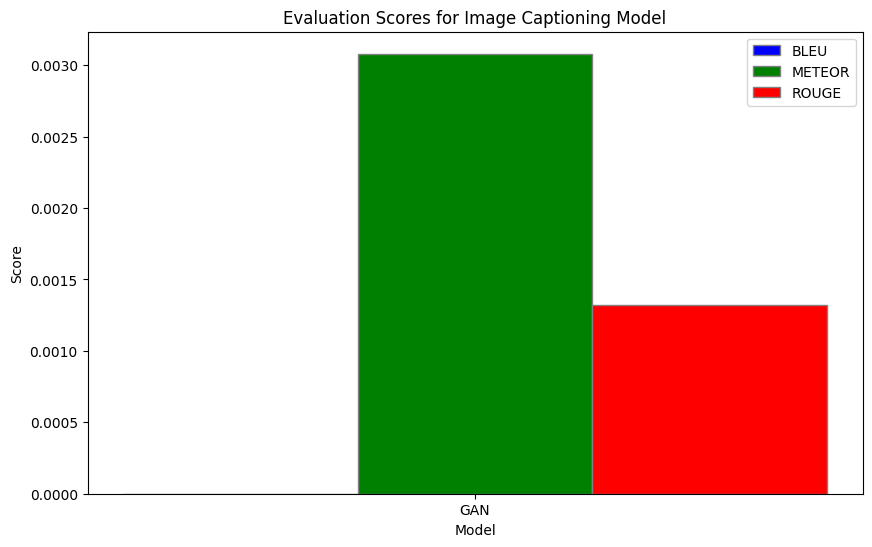

In [15]:
import numpy as np
import evaluate
from tqdm import tqdm
# Load evaluation metrics
bleu_metric = evaluate.load('bleu')
rouge_metric = evaluate.load('rouge')
meteor_metric = evaluate.load('meteor')

# Translator
translator = Translator()

# Function to translate text
def translate_text(text, src_lang='en', tgt_lang='id'):
    try:
        translated = translator.translate(text, src=src_lang, dest=tgt_lang).text
        return translated
    except Exception as e:
        return f"Error: {str(e)}"

# Generate captions and evaluate
generated_captions = []
reference_captions = []

for images, captions in tqdm(dataloader, desc="Generating Captions"):
    images = images.to(device)
    reference_caption = captions[0]

    generator.eval()
    with torch.no_grad():
        generated_caption_en = generator(images, [""])[0]  # Empty caption to trigger generation
        generated_caption_id = translate_text(generated_caption_en)

    generated_captions.append(generated_caption_id)
    reference_captions.append(reference_caption)

# Post-process text
def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [label.strip() for label in labels]
    return preds, labels

generated_captions, reference_captions = postprocess_text(generated_captions, reference_captions)

# Compute BLEU score
bleu_score = bleu_metric.compute(predictions=generated_captions, references=[[ref] for ref in reference_captions])['bleu']

# Compute ROUGE score
rouge_score = rouge_metric.compute(predictions=generated_captions, references=reference_captions)
rouge_l_f1 = rouge_score['rougeL'] if isinstance(rouge_score['rougeL'], float) else rouge_score['rougeL'].mid.fmeasure

# Compute METEOR score
meteor_score = meteor_metric.compute(predictions=generated_captions, references=reference_captions)['meteor']

# Create a DataFrame to store the results
results_df = pd.DataFrame({
    "Model": ["GAN"],
    "BLEU": [bleu_score],
    "METEOR": [meteor_score],
    "ROUGE": [rouge_l_f1]
})

# Print the results
print(results_df)

# Plot the evaluation metrics
plt.figure(figsize=(10, 6))
bar_width = 0.2
r1 = np.arange(len(results_df))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

plt.bar(r1, results_df['BLEU'], color='blue', width=bar_width, edgecolor='grey', label='BLEU')
plt.bar(r2, results_df['METEOR'], color='green', width=bar_width, edgecolor='grey', label='METEOR')
plt.bar(r3, results_df['ROUGE'], color='red', width=bar_width, edgecolor='grey', label='ROUGE')

plt.xlabel('Model')
plt.ylabel('Score')
plt.title('Evaluation Scores for Image Captioning Model')
plt.xticks([r + bar_width for r in range(len(results_df))], results_df['Model'])
plt.legend()
plt.show()
